# **THESEUS**
## **INFERENCE**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# **CONFIGURATION**

In [2]:

CONFIG_LIBRARY={

    1 :  {    "id": 1,
    "type":"LGBMClassifier",
    "parent": 0, # 0 means metamodel
    "children": None, 
    "parameters" : {},
    "make_data_func": "make_data_for_lgb",
    "fit_func": "kfold_lgb"
    
    
},
    
    2: {
    "id": 2,
    "type":"CatBoost",
    "parent": 0,
    "children" : None,
    "parameters" : {},
    "make_data_func": "make_data_for_lgb",
    "fit_func": "kfold_cat"
}
,
    0: {
    "id": 0,
    "type" : "Ensemble (LGBMClassifier, CatBoost)",
    "parent": None,
    "children" : [1,2],
    "parameters" : {},
    "make_data_func": "",
    "fit_func": "simple_avg"
    
},
    
    
    
}
    


In [3]:
from graphviz import Digraph, Source

def visualize_ensemble_structure(config):
    dot = Digraph()

    def add_nodes_edges(node):
        if node["parent"] is None:
            dot.node(str(node["id"]), label=node["type"], shape="box")
        else:
            dot.node(str(node["id"]), label=node["type"])
        if node["children"]:
            for child_id in node["children"]:
                dot.edge(str(node["id"]), str(child_id))
                add_nodes_edges(config[child_id])

    for _, node in config.items():
        add_nodes_edges(node)

    return dot

# **INFRASTRUCTURE**

In [4]:
class VotingModel():
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        
        return np.mean(y_preds, axis=0)

In [5]:
class Model:
    def __init__ (self, init_id):
        
        if init_id==0:
            print("MODEL ", init_id, " is being initialized")
        else:
            print("\tMODEL ", init_id, " is being initialized")
        if init_id not in CONFIG_LIBRARY:
            raise ValueError("Invalid input Type - class Model initialization")
        
          
        self.definition=CONFIG_LIBRARY[init_id]    

        self.state=0 
        # 0=initialized
        # 1,  for base models: fitted; for ensembles: created oof predictions
       
        self.id=init_id
        self.model_children=[]
        
        if self.definition['children'] is not None:
            print("model ", init_id, " has children ",self.definition['children'])
            for i in self.definition['children']:
             
                if i not in CONFIG_LIBRARY:
                    raise ValueError("Invalid input Type - class Model initialization")
                
                self.model_children.append(Model(i))
                
        if init_id==0:
            print("MODEL ", init_id, " has been initialized")      
        else:
            print("\tMODEL ", init_id, " has been initialized")     
       
        
        
    def train(self):
        
        print("Function train() of model ", self.id, " has started")
        if self.model_children:
            for child in self.model_children:
                child.train()
            print("All submodels of model ", self.id, " have been trained")
        
        path=None
        if self.definition["make_data_func"] is not None:
            path=self.make_data()
        
        
        
        print("Function train() of model ", self.id, " has finished")
        
    def make_data(self):
        print("Function make_data of model ", self.id, " has started")
        func = globals().get(self.definition["make_data_func"])
        if func is not None and callable(func):
            
            path=func()
        else:
            raise ValueError("Invalid input Type - make data function")
            
        
            
        return path
    
    
    def fit(self, path):
        
        
        
        print("Fit - model ", self.id, " started, path: ", path)
        func = globals().get(self.definition["fit_func"])
        if func is not None and callable(func):
            self.estimators=[]
            #self.estimators
            self.model, self.oof_preds=func(path)
            
        else:
            raise ValueError("Invalid input Type - fit function") 

     
            
       
        print("Fit - model ", self.id, " finished")
        
        
    def make_prediction():
        pd.read_parquet(path)
        test=...
        
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
        
        '''
    def predict(self):
        
    
        
    def set_oof_predictions(self, series):
        
    def get_oof_predictions(self, series):
        
    def stack(self):
    '''
    


In [28]:
def simple_average(path):
    
    
    class Average:
        def __init__(self):
            super().__init__()
        #self.estimators = estimators
        
        
        def fit(self, X, y=None):
            return self

        def predict(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series with discrete values (0 or 1)
            result = (result >= 0.5).astype(int)

            return result

        def predict_proba(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series
            result = pd.Series(result)

            return result
        
    model=Average()
        
    return model, None

In [29]:
data = {
    'column1': [1, 2, 3, 4, 5],
    'column2': [6, 7, 8, 9, 10]
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

In [30]:
model=simple_average("abc")
model.predict_proba(df)

0    3.5
1    4.5
2    5.5
3    6.5
4    7.5
dtype: float64

In [6]:
def initialization():
    
    print("Function initialization has been started")
    if not check_validity():
        raise ValueError("Invalid input Type - model configuration")
    metamodel=Model(0)
   
    print("Function initialization has been successful")
    print()
 
    return metamodel

In [7]:
def kfold_lgb(path):
    
    data=pd.read_parquet(path)
    data.drop(data[data['target'].isnull()].index, inplace=True)
    print(data.dtypes.value_counts())
    
        
        
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state= 42)
    fitted_models=[]
    oof_preds = np.zeros(data.shape[0])
    eval_results = dict()
    with tqdm(total=5) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data)), data['target'])):
            train_data = data.iloc[train_idx]
            valid_data = data.iloc[valid_idx]
            clf = LGBMClassifier()  # Create LGBMClassifier model
            clf.fit(train_data.drop('target', axis=1), train_data['target'])  # Fit the model
            fitted_models.append(clf)
            oof_preds[valid_idx]=clf.predict_proba(valid_data.drop('target', axis=1))[:,1]
            # Append the model to the list of fitted models
            pbar.update(1)
    print('Full AUC score %.6f' % roc_auc_score(data['target'], oof_preds))
    print("Confusion Matrix for Full Dataset:")
    print(confusion_matrix(data['target'], (oof_preds > 0.5).astype(int)))
    
    # Plot prediction probability histogram
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    model=VotingModel(fitted_models)
    return model, pd.Series(oof_preds, index=data['case_id'])

In [8]:
def kfold_cat(path):
    data = pd.read_parquet(path)
    data.drop(data[data['target'].isnull()].index, inplace=True)
    print(data.dtypes.value_counts())
    
    
        
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fitted_models = []
    oof_preds = np.zeros(data.shape[0])
    eval_results = dict()
    
    with tqdm(total=5) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data)), data['target'])):
            train_data = data.iloc[train_idx]
            valid_data = data.iloc[valid_idx]
            
            clf = CatBoostClassifier(iterations=1000,  # Specify the number of iterations
                                     learning_rate=0.1,  # Specify the learning rate
                                     depth=6,  # Specify the depth of the trees
                                     loss_function='Logloss',  # Specify the loss function
                                     verbose=100)  # Set verbose to print training progress
                                     
            clf.fit(train_data.drop(columns=['target', 'case_id'], axis=1),  # Train the model
                    train_data['target'],
                    eval_set=(valid_data.drop(columns=['target','case_id'], axis=1), valid_data['target']),
                    verbose_eval=100)  # Set verbose to print evaluation progress
            
            fitted_models.append(clf)
            oof_preds[valid_idx] = clf.predict_proba(valid_data.drop(columns=['target','case_id'], axis=1))[:, 1]
            pbar.update(1)
    
    print('Full AUC score %.6f' % roc_auc_score(data['target'], oof_preds))
    print("Confusion Matrix for Full Dataset:")
    print(confusion_matrix(data['target'], (oof_preds > 0.5).astype(int)))
    
    # Plot prediction probability histogram
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    
    model = VotingModel(fitted_models)  # Assuming VotingModel is defined elsewhere
    return model, pd.Series(oof_preds, index=data['case_id'])

In [9]:

def make_data_for_lgb():
    print("make_data_for_lgb started")
    # Load the Titanic dataset
    titanic_df = sns.load_dataset('titanic')

    titanic_df = pd.get_dummies(titanic_df, columns=['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alone'])
    titanic_df.drop(columns=['alive'], inplace=True)
    # Fill NaN values
    titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values

    titanic_df.rename(columns={'survived': 'target'}, inplace=True)
    
    # Add "case_id" column for every row
    titanic_df = titanic_df.assign(case_id=np.arange(len(titanic_df)))
    
    # Randomly select 10% of rows and set their "target" values to NaN
    n_rows = titanic_df.shape[0]
    n_nan_rows = int(0.1 * n_rows)  # 10% of rows
    nan_indices = np.random.choice(titanic_df.index, size=n_nan_rows, replace=False)
    titanic_df.loc[nan_indices, 'target'] = np.nan
    
    # Add WEEK_NUM column with random values
    titanic_df['WEEK_NUM'] = np.random.randint(0, 52, size=titanic_df.shape[0])
    
    # Check if 'case_id' column exists and print unique values and range
    if 'case_id' in titanic_df.columns:
        print("case_id column exists")
        if titanic_df['case_id'].is_unique:
            print("All values of case_id are unique")
        else:
            print("Values of case_id are not unique")
        print("Range of values of case_id:", titanic_df['case_id'].min(), "to", titanic_df['case_id'].max())
    else:
        print("case_id column does not exist")
    
    # Check if 'target' column exists and its values are 0, 1, or NaN, and count each
    if 'target' in titanic_df.columns:
        print("\ntarget column exists")
        print("Value counts of target column:")
        print(titanic_df['target'].value_counts(dropna=False))
    else:
        print("\ntarget column does not exist")
    
    # Check the range of values in the 'WEEK_NUM' column
    if 'WEEK_NUM' in titanic_df.columns:
        print("\nWEEK_NUM column exists")
        print("Range of values of WEEK_NUM:", titanic_df['WEEK_NUM'].min(), "to", titanic_df['WEEK_NUM'].max())
    else:
        print("\nWEEK_NUM column does not exist")
    
    # Calculate the percentage of NaN values in the DataFrame excluding 'target', 'case_id', and 'WEEK_NUM' columns
    nan_percentage = (titanic_df.drop(columns=['target', 'case_id', 'WEEK_NUM']).isna().sum().sum() / 
                      (titanic_df.shape[0] * (titanic_df.shape[1] - 3))) * 100
    print("\nPercentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): {:.2f}%".format(nan_percentage))

    path = "/kaggle/working/lgb_data.parquet"
    # Export DataFrame to Parquet
    titanic_df.to_parquet(path)
    
    print("\nmake_data_for_lgb finished")
    return path

make_data_for_lgb()


make_data_for_lgb started
case_id column exists
All values of case_id are unique
Range of values of case_id: 0 to 890

target column exists
Value counts of target column:
target
0.0    486
1.0    316
NaN     89
Name: count, dtype: int64

WEEK_NUM column exists
Range of values of WEEK_NUM: 0 to 51

Percentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): 0.00%

make_data_for_lgb finished


/tmp/ipykernel_438/2125357751.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


'/kaggle/working/lgb_data.parquet'

In [10]:
def check_validity():
    
    if not(all(isinstance(key, int) for key in CONFIG_LIBRARY.keys()) and \
       len(CONFIG_LIBRARY.keys()) == len(set(CONFIG_LIBRARY.keys())) and \
       all(isinstance(value, dict) for value in CONFIG_LIBRARY.values())):
        # Your code here if all conditions are met
  
        return False
    
    
    required_keys = {
    "id", "type", "parent", "children", "parameters", "make_data_func", "fit_func"
}
    

    
    for library in CONFIG_LIBRARY.values():
        if not required_keys.issubset(library.keys()):
        
            return False
        
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["type"], str):
            #print("The value associated with the key 'id' is an integer.")
        
            print("The value associated with the key 'type' is either missing or not an integer.")
            return False
        

    
    
    return True

In [ ]:
def generate_submission_file(metamodel):
    
    metamodel.make_prediction()
    
    y_preds=metamodel.predict_proba(test_ids)
    

In [11]:
def fit_models(metamodel):
    
    print("Function fit_models has been started")
    
    metamodel.train()
    
    
    
    if meta.model_children is None:
        print("Training of model ", child.id, " has started")
        path=meta.make_data()
        meta.fit(path)
        print("Training of model ", child.id, " has been successful")
        print()
    
    for child in meta.model_children:
        
        #print(base_model.definition)
        # iteration to get to the base model
        print("Training of model ", child.id, " has started")
        #print(children.definition["make_data_func"])
        path=child.make_data()
        child.fit(path)
        print("Training of model ", child.id, " has been successful")
        print()
    
    # iterate through children
    
    
    
    
  

In [12]:
def main(debug=False):
    
    metamodel=initialization()
    # Creates dummy version of the models.
    
    metamodel=fit_models(metamodel)
    # It trains models, it goes from apex down to the base models.
    # It creates oof predictions.
    
    #metamodel=ensemble_models(metamodel)
    
    #It sets the blending technique/
    # Now, predict_proba in metamodel is ready to be called.
    
    metamodel.predict_proba(pd.Series([1,2,3]))
    
    generate_submission_file()
    

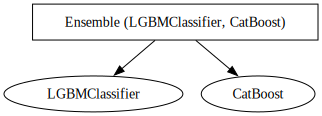

In [13]:
visualize_ensemble_structure(CONFIG_LIBRARY)

/tmp/ipykernel_438/2125357751.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


Function initialization has been started
MODEL  0  is being initialized
model  0  has children  [1, 2]
	MODEL  1  is being initialized
	MODEL  1  has been initialized
	MODEL  2  is being initialized
	MODEL  2  has been initialized
MODEL  0  has been initialized
Function initialization has been successful

Function fit_models has been started
Training of model  1  has started
Function make_data of model  1  has started
make_data_for_lgb started
case_id column exists
All values of case_id are unique
Range of values of case_id: 0 to 890

target column exists
Value counts of target column:
target
0.0    489
1.0    313
NaN     89
Name: count, dtype: int64

WEEK_NUM column exists
Range of values of WEEK_NUM: 0 to 51

Percentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): 0.00%

make_data_for_lgb finished
Fit - model  1  started, path:  /kaggle/working/lgb_data.parquet
bool       24
int64       5
float64     3
Name: count, dtype: int64


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 250, number of negative: 391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390016 -> initscore=-0.447247
[LightGBM] [Info] Start training from score -0.447247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 20%|██        | 1/5 [00:00<00:01,  3.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 60%|██████    | 3/5 [00:00<00:00,  8.95it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 5/5 [00:00<00:00, 10.06it/s]

[LightGBM] [Info] Number of positive: 250, number of negative: 392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389408 -> initscore=-0.449801
[LightGBM] [Info] Start training from score -0.449801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

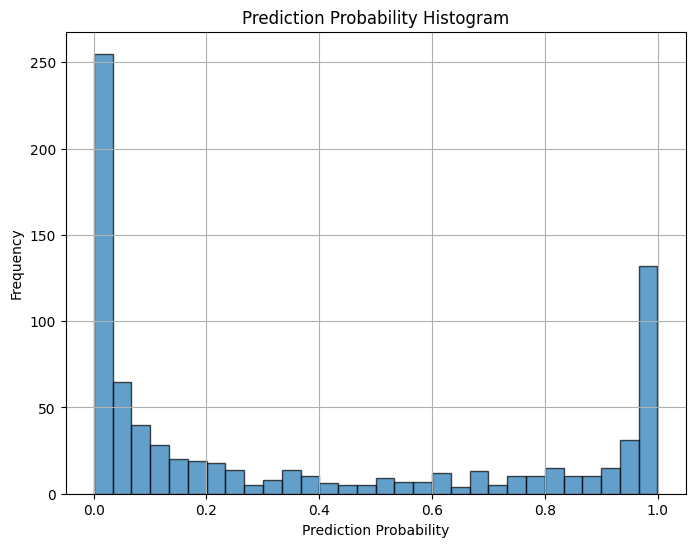

/tmp/ipykernel_438/2125357751.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


Fit - model  1  finished
Training of model  1  has been successful

Training of model  2  has started
Function make_data of model  2  has started
make_data_for_lgb started
case_id column exists
All values of case_id are unique
Range of values of case_id: 0 to 890

target column exists
Value counts of target column:
target
0.0    497
1.0    305
NaN     89
Name: count, dtype: int64

WEEK_NUM column exists
Range of values of WEEK_NUM: 0 to 51

Percentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): 0.00%

make_data_for_lgb finished
Fit - model  2  started, path:  /kaggle/working/lgb_data.parquet
bool       24
int64       5
float64     3
Name: count, dtype: int64


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6371755	test: 0.6374393	best: 0.6374393 (0)	total: 49.4ms	remaining: 49.4s
100:	learn: 0.2157184	test: 0.3993546	best: 0.3881136 (40)	total: 208ms	remaining: 1.85s
200:	learn: 0.1217265	test: 0.4296750	best: 0.3881136 (40)	total: 386ms	remaining: 1.54s
300:	learn: 0.0750621	test: 0.4567803	best: 0.3881136 (40)	total: 562ms	remaining: 1.3s
400:	learn: 0.0520497	test: 0.4735109	best: 0.3881136 (40)	total: 736ms	remaining: 1.1s
500:	learn: 0.0390921	test: 0.4902071	best: 0.3881136 (40)	total: 913ms	remaining: 909ms
600:	learn: 0.0295569	test: 0.5108911	best: 0.3881136 (40)	total: 1.08s	remaining: 720ms
700:	learn: 0.0240925	test: 0.5253905	best: 0.3881136 (40)	total: 1.25s	remaining: 535ms
800:	learn: 0.0203471	test: 0.5398110	best: 0.3881136 (40)	total: 1.43s	remaining: 354ms
900:	learn: 0.0178036	test: 0.5497991	best: 0.3881136 (40)	total: 1.58s	remaining: 174ms
999:	learn: 0.0162187	test: 0.5577242	best: 0.3881136 (40)	total: 1.74s	remaining: 0us

bestTest = 0.3881135547
be

 20%|██        | 1/5 [00:01<00:07,  1.91s/it]

0:	learn: 0.6430280	test: 0.6447063	best: 0.6447063 (0)	total: 826us	remaining: 825ms
100:	learn: 0.1878614	test: 0.4511953	best: 0.4133486 (25)	total: 149ms	remaining: 1.32s
200:	learn: 0.0982514	test: 0.4743413	best: 0.4133486 (25)	total: 302ms	remaining: 1.2s
300:	learn: 0.0580804	test: 0.5241210	best: 0.4133486 (25)	total: 474ms	remaining: 1.1s
400:	learn: 0.0406493	test: 0.5543961	best: 0.4133486 (25)	total: 647ms	remaining: 966ms
500:	learn: 0.0303617	test: 0.5752377	best: 0.4133486 (25)	total: 820ms	remaining: 817ms
600:	learn: 0.0236879	test: 0.5977623	best: 0.4133486 (25)	total: 993ms	remaining: 659ms
700:	learn: 0.0193318	test: 0.6184024	best: 0.4133486 (25)	total: 1.16s	remaining: 496ms
800:	learn: 0.0166408	test: 0.6263246	best: 0.4133486 (25)	total: 1.33s	remaining: 332ms
900:	learn: 0.0143039	test: 0.6373733	best: 0.4133486 (25)	total: 1.51s	remaining: 166ms
999:	learn: 0.0122377	test: 0.6557071	best: 0.4133486 (25)	total: 1.68s	remaining: 0us

bestTest = 0.4133486336
bes

 40%|████      | 2/5 [00:03<00:05,  1.86s/it]

0:	learn: 0.6441386	test: 0.6463297	best: 0.6463297 (0)	total: 1.13ms	remaining: 1.13s
100:	learn: 0.2141567	test: 0.3860323	best: 0.3743606 (58)	total: 145ms	remaining: 1.29s
200:	learn: 0.1122953	test: 0.3942217	best: 0.3743606 (58)	total: 281ms	remaining: 1.12s
300:	learn: 0.0672784	test: 0.4160918	best: 0.3743606 (58)	total: 443ms	remaining: 1.03s
400:	learn: 0.0455130	test: 0.4364311	best: 0.3743606 (58)	total: 621ms	remaining: 928ms
500:	learn: 0.0330178	test: 0.4528332	best: 0.3743606 (58)	total: 804ms	remaining: 801ms
600:	learn: 0.0252715	test: 0.4713878	best: 0.3743606 (58)	total: 981ms	remaining: 651ms
700:	learn: 0.0206782	test: 0.4846547	best: 0.3743606 (58)	total: 1.16s	remaining: 496ms
800:	learn: 0.0172971	test: 0.4997078	best: 0.3743606 (58)	total: 1.34s	remaining: 332ms
900:	learn: 0.0150209	test: 0.5090652	best: 0.3743606 (58)	total: 1.51s	remaining: 166ms
999:	learn: 0.0133114	test: 0.5136381	best: 0.3743606 (58)	total: 1.68s	remaining: 0us

bestTest = 0.3743605827


 60%|██████    | 3/5 [00:05<00:03,  1.85s/it]

0:	learn: 0.6316886	test: 0.6405207	best: 0.6405207 (0)	total: 1.16ms	remaining: 1.16s
100:	learn: 0.1632778	test: 0.6365502	best: 0.5237822 (9)	total: 157ms	remaining: 1.4s
200:	learn: 0.0815454	test: 0.7454040	best: 0.5237822 (9)	total: 305ms	remaining: 1.21s
300:	learn: 0.0478481	test: 0.8279912	best: 0.5237822 (9)	total: 463ms	remaining: 1.08s
400:	learn: 0.0318834	test: 0.9067949	best: 0.5237822 (9)	total: 624ms	remaining: 932ms
500:	learn: 0.0232246	test: 0.9618081	best: 0.5237822 (9)	total: 796ms	remaining: 793ms
600:	learn: 0.0179785	test: 1.0066449	best: 0.5237822 (9)	total: 971ms	remaining: 645ms
700:	learn: 0.0151013	test: 1.0364967	best: 0.5237822 (9)	total: 1.15s	remaining: 490ms
800:	learn: 0.0125037	test: 1.0723348	best: 0.5237822 (9)	total: 1.32s	remaining: 329ms
900:	learn: 0.0110487	test: 1.1010636	best: 0.5237822 (9)	total: 1.49s	remaining: 164ms
999:	learn: 0.0099155	test: 1.1239366	best: 0.5237822 (9)	total: 1.66s	remaining: 0us

bestTest = 0.5237822051
bestIterati

 80%|████████  | 4/5 [00:07<00:01,  1.84s/it]

0:	learn: 0.6398032	test: 0.6342152	best: 0.6342152 (0)	total: 1.17ms	remaining: 1.17s
100:	learn: 0.2131749	test: 0.3636532	best: 0.3523745 (50)	total: 142ms	remaining: 1.26s
200:	learn: 0.1112312	test: 0.3846814	best: 0.3523745 (50)	total: 298ms	remaining: 1.18s
300:	learn: 0.0663170	test: 0.3971030	best: 0.3523745 (50)	total: 471ms	remaining: 1.09s
400:	learn: 0.0442045	test: 0.4200457	best: 0.3523745 (50)	total: 643ms	remaining: 960ms
500:	learn: 0.0314268	test: 0.4375657	best: 0.3523745 (50)	total: 815ms	remaining: 811ms
600:	learn: 0.0250189	test: 0.4482946	best: 0.3523745 (50)	total: 986ms	remaining: 654ms
700:	learn: 0.0203978	test: 0.4644932	best: 0.3523745 (50)	total: 1.16s	remaining: 494ms
800:	learn: 0.0170768	test: 0.4759713	best: 0.3523745 (50)	total: 1.33s	remaining: 330ms
900:	learn: 0.0147636	test: 0.4832101	best: 0.3523745 (50)	total: 1.5s	remaining: 165ms
999:	learn: 0.0128327	test: 0.4922630	best: 0.3523745 (50)	total: 1.68s	remaining: 0us

bestTest = 0.3523745252
b

100%|██████████| 5/5 [00:09<00:00,  1.85s/it]

Full AUC score 0.875169
Confusion Matrix for Full Dataset:
[[447  50]
 [ 91 214]]


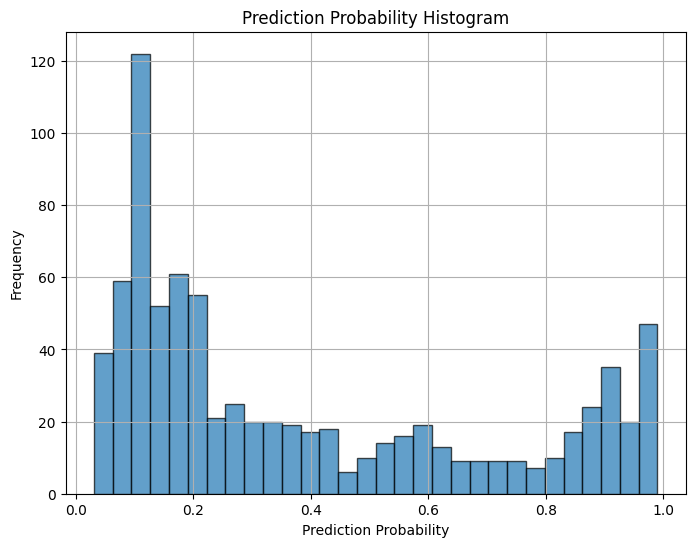

Fit - model  2  finished
Training of model  2  has been successful



In [14]:
main()